<a href="https://colab.research.google.com/github/GabrielaMorera/ModeloIA_Ecommerce/blob/main/Trabajo_final_CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo final: Reconocimiento de dígitos escritos a mano usando CNN en PyTorch**

## Descripción General
Este código implementa un sistema completo de reconocimiento de dígitos manuscritos usando una Red Neuronal Convolucional (CNN). Permite entrenar un modelo con el dataset MNIST y utilizarlo para reconocer dígitos en imágenes subidas por el usuario.

**Integrantes:**

*   Gabriela Morera


**Profesor:**

*   Juan Fernando Zea


### Importación de librerías

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os
from google.colab import files

### Sección 1: Parámetros de entrenamiento y configuración de hardware

In [2]:
EPOCHS = 20
TRAIN_BATCH = 64
TEST_BATCH = 1000
LR = 0.01
MOMENTUM = 0.5
LOG_CADA = 100
SEMILLA = 1
torch.manual_seed(SEMILLA)
dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
archivo_modelo = 'mnist_cnn_mejorado.pt'

### Sección 2: Transformaciones y Datasets

In [3]:
# Transformaciones para entrenamiento (con aumentación)
transf_entrenamiento = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Transformaciones para pruebas (sin aumentación)
transf_prueba = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Carga de datasets
dataset_train = datasets.MNIST('.', train=True, download=True, transform=transf_entrenamiento)
dataset_test = datasets.MNIST('.', train=False, download=True, transform=transf_prueba)

# Creación de dataloaders
cargador_train = DataLoader(dataset_train, batch_size=TRAIN_BATCH, shuffle=True)
cargador_test = DataLoader(dataset_test, batch_size=TEST_BATCH, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 450kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.42MB/s]


### Sección 3: Definición de la CNN

In [4]:
class RedCNN(nn.Module):
    def __init__(self):
        super(RedCNN, self).__init__()
        # Primera capa convolucional: 1 canal entrada (gris) → 32 filtros, kernel 3x3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)

        # Segunda capa convolucional: 32 canales → 64 filtros, kernel 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Capa de pooling para reducir dimensionalidad
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Capas de dropout para prevenir sobreajuste
        self.dropout1 = nn.Dropout2d(0.25)  # Para capas convolucionales
        self.dropout2 = nn.Dropout(0.5)     # Para capas fully connected

        # Primera capa fully connected: 64 filtros * 7 * 7 → 128 neuronas
        self.fc1 = nn.Linear(64 * 7 * 7, 128)

        # Capa de salida: 128 → 10 (los dígitos 0-9)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Primera etapa: convolución → activación → pooling
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        # Segunda etapa: convolución → activación → pooling
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Aplicamos dropout y aplanamos para las capas fully connected
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # aplanar todos los dims excepto el batch

        # Tercera etapa: fully connected → activación → dropout
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Capa de salida (sin activación - la pérdida CrossEntropy lo maneja)
        x = self.fc2(x)

        return x

### Sección 4: Inicialización del Modelo y Optimizador

In [5]:
# Inicialización del modelo y envío al dispositivo (CPU/GPU)
modelo = RedCNN().to(dispositivo)

# Definición del optimizador (SGD con momentum)
optimizador = optim.SGD(modelo.parameters(), lr=LR, momentum=MOMENTUM)

# Función de pérdida (Cross Entropy para clasificación)
criterio = nn.CrossEntropyLoss()

### Sección 5: Funciones de Entrenamiento y Evaluación

In [6]:
# Función para entrenar por una época
def entrenar(epoca):
    modelo.train()  # Modo entrenamiento
    for batch_idx, (datos, etiquetas) in enumerate(cargador_train):
        # Mover datos al dispositivo
        datos, etiquetas = datos.to(dispositivo), etiquetas.to(dispositivo)

        # Reiniciar gradientes
        optimizador.zero_grad()

        # Forward pass
        salida = modelo(datos)

        # Cálculo de pérdida
        perdida = criterio(salida, etiquetas)

        # Backward pass
        perdida.backward()

        # Actualizar pesos
        optimizador.step()

        # Mostrar progreso
        if batch_idx % LOG_CADA == 0:
            print(f'Entrenando Época: {epoca} [{batch_idx * len(datos)}/{len(cargador_train.dataset)} '
                  f'({100. * batch_idx / len(cargador_train):.0f}%)]\tPérdida: {perdida.item():.6f}')


# Función para evaluar en el set de prueba
def evaluar():
    modelo.eval()  # Modo evaluación
    perdida_test = 0
    aciertos = 0

    # No calculamos gradientes en evaluación
    with torch.no_grad():
        for datos, etiquetas in cargador_test:
            datos, etiquetas = datos.to(dispositivo), etiquetas.to(dispositivo)

            # Forward pass
            salida = modelo(datos)

            # Acumular pérdida
            perdida_test += criterio(salida, etiquetas).item()

            # Obtener predicciones
            predicciones = salida.argmax(dim=1, keepdim=True)

            # Contar aciertos
            aciertos += predicciones.eq(etiquetas.view_as(predicciones)).sum().item()

    # Calcular métricas finales
    perdida_test /= len(cargador_test.dataset)
    precision = 100. * aciertos / len(cargador_test.dataset)

    print(f'\nSet de prueba: Pérdida promedio: {perdida_test:.4f}, '
          f'Precisión: {aciertos}/{len(cargador_test.dataset)} ({precision:.2f}%)\n')

    return precision

### Sección 6: Ciclo de Entrenamiento

In [7]:
# Entrenamiento principal
print("\n🚀 Iniciando entrenamiento con aumentación de datos...")
mejor_precision = 0.0

for epoca in range(1, EPOCHS + 1):
    print(f"\n--- Época {epoca}/{EPOCHS} ---")
    entrenar(epoca)
    precision_actual = evaluar()

    # Guardar el mejor modelo
    if precision_actual > mejor_precision:
        mejor_precision = precision_actual
        torch.save(modelo.state_dict(), archivo_modelo)
        print(f"✅ Nuevo mejor modelo guardado con precisión: {mejor_precision:.2f}%")

print("\n🎉 Entrenamiento completado con éxito!")
print(f"Mejor precisión alcanzada: {mejor_precision:.2f}%")


🚀 Iniciando entrenamiento con aumentación de datos...

--- Época 1/20 ---
Entrenando Época: 1 [0/60000 (0%)]	Pérdida: 2.320374
Entrenando Época: 1 [6400/60000 (11%)]	Pérdida: 1.616506
Entrenando Época: 1 [12800/60000 (21%)]	Pérdida: 1.154117
Entrenando Época: 1 [19200/60000 (32%)]	Pérdida: 0.759158
Entrenando Época: 1 [25600/60000 (43%)]	Pérdida: 0.765445
Entrenando Época: 1 [32000/60000 (53%)]	Pérdida: 0.602253
Entrenando Época: 1 [38400/60000 (64%)]	Pérdida: 0.639222
Entrenando Época: 1 [44800/60000 (75%)]	Pérdida: 0.477928
Entrenando Época: 1 [51200/60000 (85%)]	Pérdida: 0.342958
Entrenando Época: 1 [57600/60000 (96%)]	Pérdida: 0.359602

Set de prueba: Pérdida promedio: 0.0001, Precisión: 9618/10000 (96.18%)

✅ Nuevo mejor modelo guardado con precisión: 96.18%

--- Época 2/20 ---
Entrenando Época: 2 [0/60000 (0%)]	Pérdida: 0.326211
Entrenando Época: 2 [6400/60000 (11%)]	Pérdida: 0.361404
Entrenando Época: 2 [12800/60000 (21%)]	Pérdida: 0.367045
Entrenando Época: 2 [19200/60000 (32%

### Sección 7: Carga del Modelo para Predicción

In [8]:
# Cargar el mejor modelo entrenado
if os.path.exists(archivo_modelo):
    modelo_prediccion = RedCNN().to(dispositivo)
    try:
        modelo_prediccion.load_state_dict(torch.load(archivo_modelo, map_location=dispositivo))
        modelo_prediccion.eval()
        print(f"✅ Modelo cargado correctamente desde '{archivo_modelo}'")
    except Exception as e:
        print(f"❌ ERROR al cargar el modelo: {e}")
        raise RuntimeError("No se pudo cargar el modelo entrenado.") from e
else:
    print(f"❌ ERROR: No se encontró el archivo de modelo '{archivo_modelo}'")
    raise FileNotFoundError(f"Archivo de modelo no encontrado: {archivo_modelo}")

# Transformaciones para la predicción
transformaciones_finales = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

✅ Modelo cargado correctamente desde 'mnist_cnn_mejorado.pt'


### Sección 8: Función para Preprocesar ROIs

In [9]:
# Función para preprocesar ROIs manteniendo la proporción
def preprocesar_roi(roi_img, tamano_destino=28, tamano_ajuste=20):
    """
    Preprocesa una región de interés (ROI) preservando su proporción de aspecto
    """
    try:
        # Obtener dimensiones
        alto, ancho = roi_img.shape
        if alto == 0 or ancho == 0:
            return None

        # Redimensionar preservando proporción
        if ancho >= alto:
            nuevo_ancho = tamano_ajuste
            nuevo_alto = max(1, int(alto * (tamano_ajuste / ancho)))
        else:
            nuevo_alto = tamano_ajuste
            nuevo_ancho = max(1, int(ancho * (tamano_ajuste / alto)))

        # Redimensionar ROI
        roi_redimensionada = cv2.resize(roi_img, (nuevo_ancho, nuevo_alto),
                                        interpolation=cv2.INTER_AREA)

        # Calcular relleno necesario
        delta_ancho = tamano_destino - nuevo_ancho
        delta_alto = tamano_destino - nuevo_alto

        arriba = delta_alto // 2
        abajo = delta_alto - (delta_alto // 2)
        izquierda = delta_ancho // 2
        derecha = delta_ancho - (delta_ancho // 2)

        # Aplicar relleno (padding)
        roi_rellenada = cv2.copyMakeBorder(
            roi_redimensionada, arriba, abajo, izquierda, derecha,
            cv2.BORDER_CONSTANT, value=0
        )

        # Convertir a formato PIL
        roi_pil = transforms.ToPILImage()(roi_rellenada)

        # Aplicar transformaciones y mover al dispositivo
        tensor_entrada = transformaciones_finales(roi_pil).to(dispositivo)

        # Añadir dimensión de batch si es necesario
        if len(tensor_entrada.shape) == 3:
            tensor_entrada = tensor_entrada.unsqueeze(0)

        # Verificar forma correcta
        if tensor_entrada.shape == (1, 1, tamano_destino, tamano_destino):
            return tensor_entrada
        else:
            return None

    except Exception as e:
        print(f"Error en preprocesamiento: {e}")
        return None

### Sección 9: Carga y Preprocesamiento de Imagen


📁 Por favor, sube una imagen con dígitos para reconocer:


Saving ceroanueve.jpeg to ceroanueve.jpeg

✅ Archivo recibido: 'ceroanueve.jpeg' (28458 bytes)

🖼️ Imagen original:


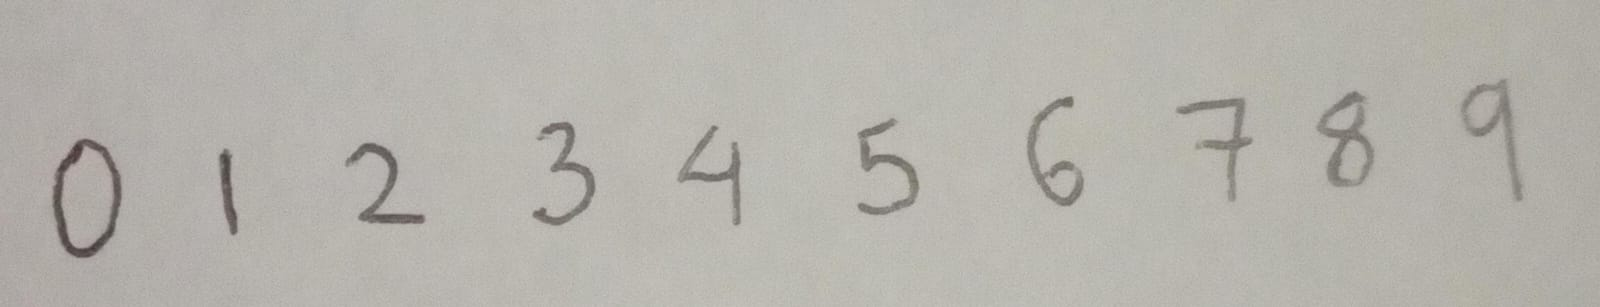

In [10]:
# Solicitar imagen al usuario
print("\n📁 Por favor, sube una imagen con dígitos para reconocer:")
archivos_subidos = files.upload()

if len(archivos_subidos) == 0:
    print("❌ No se subió ningún archivo. Finalizando.")
    exit()

nombre_archivo = list(archivos_subidos.keys())[0]
print(f"\n✅ Archivo recibido: '{nombre_archivo}' ({len(archivos_subidos[nombre_archivo])} bytes)")

# Cargar y preprocesar la imagen
datos_imagen = archivos_subidos[nombre_archivo]
array_np = np.frombuffer(datos_imagen, np.uint8)
imagen_original = cv2.imdecode(array_np, cv2.IMREAD_COLOR)

if imagen_original is None:
    print(f"❌ Error: No se pudo decodificar '{nombre_archivo}' como imagen.")
    exit()

# Convertir a escala de grises
imagen_gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)

# Aplicar umbral (threshold) para binarizar
UMBRAL = 150  # Valor que funciona bien para la mayoría de los casos
_, imagen_binaria = cv2.threshold(imagen_gris, UMBRAL, 255, cv2.THRESH_BINARY_INV)

print("\n🖼️ Imagen original:")
cv2_imshow(imagen_original)

### Sección 10: Detección y Predicción de Dígitos


🔍 Se encontraron 12 posibles dígitos.
✅ Se procesaron correctamente 10 dígitos.

🏁 Proceso completado!
Mostrando imagen con las predicciones:


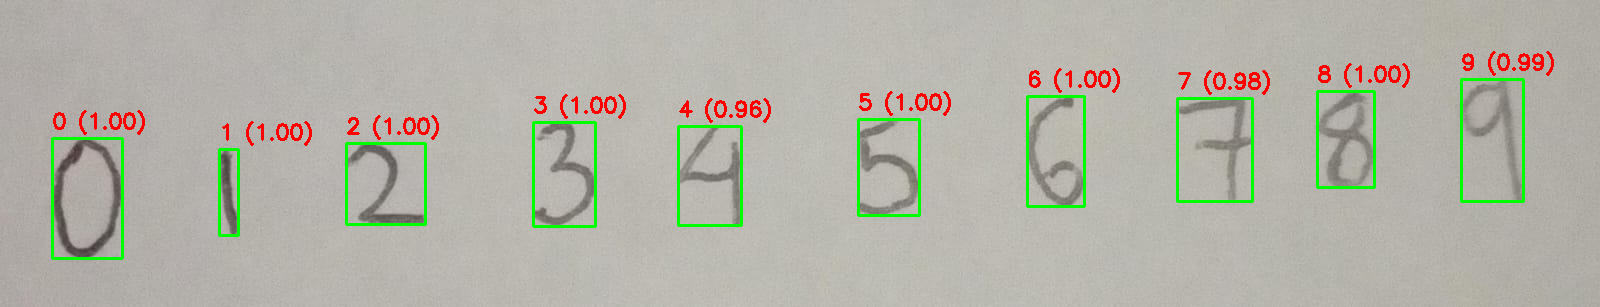

In [11]:
# Encontrar contornos
contornos, _ = cv2.findContours(imagen_binaria.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"\n🔍 Se encontraron {len(contornos)} posibles dígitos.")

# Copiar imagen para mostrar resultados
imagen_resultados = imagen_original.copy()
contornos_procesados = 0

# Parámetros de filtrado
ANCHO_MIN = 5
ALTO_MIN = 10

# Procesar cada contorno
for contorno in contornos:
    # Obtener rectángulo delimitador
    x, y, ancho, alto = cv2.boundingRect(contorno)

    # Filtrar contornos demasiado pequeños
    if ancho > ANCHO_MIN and alto > ALTO_MIN:
        contornos_procesados += 1

        # Extraer región de interés (ROI)
        roi = imagen_binaria[y:y+alto, x:x+ancho]

        # Preprocesar ROI preservando proporción
        tensor_entrada = preprocesar_roi(roi, tamano_destino=28, tamano_ajuste=20)

        if tensor_entrada is not None:
            try:
                # Realizar predicción
                with torch.no_grad():
                    salida = modelo_prediccion(tensor_entrada)
                    probabilidades = F.softmax(salida, dim=1)
                    prob_max, etiqueta_pred = torch.max(probabilidades, 1)
                    digito_predicho = etiqueta_pred.item()
                    confianza = prob_max.item()

                # Dibujar rectángulo y predicción
                cv2.rectangle(imagen_resultados, (x, y), (x + ancho, y + alto), (0, 255, 0), 2)
                texto = f"{digito_predicho} ({confianza:.2f})"
                cv2.putText(imagen_resultados, texto, (x, y - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            except Exception as e:
                print(f"⚠️ Error al procesar el dígito en ({x},{y}): {e}")

print(f"✅ Se procesaron correctamente {contornos_procesados} dígitos.")

# Mostrar resultados finales
print("\n🏁 Proceso completado!")
print("Mostrando imagen con las predicciones:")
cv2_imshow(imagen_resultados)

## Parámetros Importantes

1. **Umbral de Binarización (UMBRAL = 150):**
   - Valor fijo que funciona bien para la mayoría de las imágenes con buen contraste
   - Para imágenes con bajo contraste podría ser necesario ajustar este valor

2. **Filtros de Contorno (ANCHO_MIN = 5, ALTO_MIN = 10):**
   - Ayudan a filtrar elementos que no son dígitos
   - Ajustar según las características de las imágenes a procesar

3. **Parámetros de preprocesamiento (tamano_destino=28, tamano_ajuste=20):**
   - tamano_destino: dimensión final de la imagen (coincide con MNIST)
   - tamano_ajuste: dimensión máxima durante el redimensionamiento que preserva la relación de aspecto

## Notas Adicionales

1. **Entrenamiento con Aumentación de Datos:**
   - Las transformaciones aleatorias (rotación, traslación, escala) mejoran la robustez del modelo
   - Ayuda a que el modelo generalice mejor para reconocer dígitos en diferentes estilos de escritura

2. **Preservación de la Relación de Aspecto:**
   - Mantener la proporción original del dígito es crucial para una correcta clasificación
   - Evita distorsiones que podrían hacer que, por ejemplo, un '1' se parezca a un '7'

3. **Uso de Dropout:**
   - Las dos capas de dropout (25% y 50%) son fundamentales para prevenir el sobreajuste
   - Permiten que el modelo generalice mejor a datos no vistos durante el entrenamiento

4. **Comparación con Métodos Alternativos:**
   - El threshold manual (150) ofreció mejores resultados que los métodos adaptativos de umbralización
   - El enfoque de preservación de aspecto superó a la simple redimensión a 28x28
   - La arquitectura CNN elegida balanceó eficazmente precisión y complejidad